In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.io import loadmat
import pickle
import matplotlib.pyplot as plt

In [2]:
path_folder_unprocessed_kpg193 = Path.cwd().resolve() / "data" / "input" / "unprocessed" / "KPG193_ver1_2"
path_folder_processed_kpg193 = Path.cwd().resolve() / "data" / "input" / "processed" / "KPG193_ver1_2"
path_folder_processed_kpg193.mkdir(parents=True, exist_ok=True)

**Timestamp (2022)**

In [3]:
timestamp_2022 = np.arange(np.datetime64("2022-01-01T00"), np.datetime64("2023-01-01T00"))
np.save(Path.cwd() / "data" / "input" / "processed" / "timestamp_2022.npy", timestamp_2022)

**Thermal Generators**

In [4]:
raw = loadmat(path_folder_unprocessed_kpg193 / "network" / "mat" / "KPG193_ver1_2.mat")["mpc"][0, 0]

In [5]:
# [KPG193] 1 $ = 1000 KRW
fx_rate = 1000

# [KPG193] 0: Nuclear, 1: Coal, 2: LNG, 3: Renewable
unit_type = np.array([
    1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
    2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 
    0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
], dtype=np.uint8)

cost_const, cost_lin, cost_quad = (raw["gencost"][:, [-1, -2, -3]] * fx_rate).transpose()
p_max, p_min = raw["gen"][:, [8, 9]].transpose()

(
    ramp_up,
    ramp_down,
    startup_ramp,
    shutdown_ramp,
    min_up,
    min_down,
) = raw["genthermal"][:, [5, 6, 7, 8, 1, 2]].transpose()
min_up, min_down = min_up.astype(int), min_down.astype(int)

cost_startup_step = []
for idx_unit, (cost_startup_pseudo_i, startup_delay_i) in enumerate(zip(
    (raw["genthermal"][:, -6:-3] * fx_rate).tolist(),   # startupi
    raw["genthermal"][:, -3:].astype(int)               # "startupdelayi"
)):
    
    cost_startup_step.append(
            [cost_startup_pseudo_i[0]] * startup_delay_i[0]
            + [cost_startup_pseudo_i[1]] * (startup_delay_i[1] - startup_delay_i[0])
            + [cost_startup_pseudo_i[2]] * (startup_delay_i[2] - startup_delay_i[1])
        )

**Mustoff (2022)**

In [6]:
def get_must_off_2022():
    mustoff_2022 = pd.read_csv(path_folder_unprocessed_kpg193 / "mustoff/nuclear_mustoff.csv").to_numpy()

    # [KPG193] mustoff 'off_end_day' exceeding 365
    mask_exceed_365 = mustoff_2022[:, 3] > 365
    mustoff_2022[:, 3][mask_exceed_365] = 365
    mustoff_2022[:, 4][mask_exceed_365] = 24

    mustoff_2022 -= 1 # 0-based indexing bus and time
    mustoff_2022[:, 1] = mustoff_2022[:, 1] * 24 + mustoff_2022[:, 2]
    mustoff_2022[:, 2] = mustoff_2022[:, 3] * 24 + mustoff_2022[:, 4]

    return mustoff_2022[:, :3] # unit; mustoff_start; mustoff_end

mustoff_2022 = get_must_off_2022()

**Demands (2022)**

In [7]:
def get_demand_2022():
    demand_2022 = np.empty((365, 24, 197))
    path_folder_per_bus_demand = path_folder_unprocessed_kpg193 / "profile" / "demand"
    
    for day in range(365):
        demand_2022[day] = (
            pd.read_csv(path_folder_per_bus_demand / f"daily_demand_{day + 1}.csv")
            .drop(columns="demandQ")
            .sort_values(by=["hour", "bus_id"])
            [["demandP"]]
            .values
            .reshape((24, 197))
        )

    return demand_2022.reshape((8760, 197))

demand_2022 = get_demand_2022()

**Status (2022)**

In [8]:
def get_status_2022():
    status_2022 = np.empty((365, 24, 122), dtype=np.uint8)
    path_folder_per_unit_status = path_folder_unprocessed_kpg193 / "profile" / "commitment_decision"

    for day in range(365):
        status_2022[day] = (
            pd.read_csv(path_folder_per_unit_status / f"commitment_decision_{day + 1}.csv")
            .sort_values(by=["hour", "generator_id"])
            [["status"]]
            .values
            .reshape((24, 122))
        )

    return status_2022.reshape((8760, 122))

status_2022 = get_status_2022()

**Renewable Generation (2022)**

In [9]:
def get_renewable_ratio_2022():
    solar_ratio_2022, wind_ratio_2022, hydro_ratio_2022 = np.empty((365, 24, 197)), np.empty((365, 24, 197)), np.empty((365, 24, 197))
    path_folder_reg_profile = path_folder_unprocessed_kpg193 / "profile" / "renewables"
    
    for day in range(365):

        df = (
            pd.read_csv(path_folder_reg_profile / f"renewables_{day + 1}.csv")
            # [KPG193] random CSV nans
            .fillna(0)
            # [KPG193] missing bus 151, duplicate 153 lines for 24 hours
            .assign(bus_id=lambda d: d.bus_id.where(d.bus_id != 152, 151))
            .pipe(lambda d: pd.concat(
                [
                    d[d.bus_id != 153],
                    (
                        d
                        .query("bus_id == 153")
                        .drop_duplicates("hour")
                        .pipe(lambda x: pd.concat([x.assign(bus_id=152),x.assign(bus_id=153)]))
                    )
                ],
                ignore_index=True
            ))
            .sort_values(["hour", "bus_id"])
        )

        solar_ratio_2022[day] = df.pv_profile_ratio.values.reshape(24, 197)
        wind_ratio_2022[day] = df.wind_profile_ratio.values.reshape(24, 197)
        hydro_ratio_2022[day] = df.hydro_profile_ratio.values.reshape(24, 197)

    return solar_ratio_2022.reshape((8760, 197)), wind_ratio_2022.reshape((8760, 197)), hydro_ratio_2022.reshape((8760, 197))


def get_renewable_capacity_2022():
    # [KPG193] 4 missing buses in solar and hydro
    solar_capacity_2022, wind_capacity_2022, hydro_capacity_2022 = np.zeros(197), np.zeros(197), np.zeros(197)
    path_folder_reg_capacity = path_folder_unprocessed_kpg193 / "renewables_capacity"
    reg_dict = {"solar": solar_capacity_2022, "wind": wind_capacity_2022, "hydro": hydro_capacity_2022}

    for reg_str, reg_var in reg_dict.items():
        raw = (
            pd.read_csv(path_folder_reg_capacity / f"{reg_str}_generators_2022.csv")
            # [KPG193] random CSV nans
            .fillna(0)
            [["bus_ID", "Pmax [MW]"]]
        )
        # [KPG193] 4 missing buses in solar and hydro
        reg_var[raw["bus_ID"].values - 1] = raw["Pmax [MW]"].values 
    
    return solar_capacity_2022, wind_capacity_2022, hydro_capacity_2022


solar_ratio_2022, wind_ratio_2022, hydro_ratio_2022 = get_renewable_ratio_2022()
solar_capacity_2022, wind_capacity_2022, hydro_capacity_2022 = get_renewable_capacity_2022()
solar_p_max_2022, wind_p_2022, hydro_p_2022 = solar_ratio_2022 * solar_capacity_2022, wind_ratio_2022 * wind_capacity_2022, hydro_ratio_2022 * hydro_capacity_2022

In [10]:
for var_str in [
    "unit_type",
    "cost_const",
    "cost_lin",
    "cost_quad",
    "p_max",
    "p_min",
    "ramp_up",
    "ramp_down",
    "startup_ramp",
    "shutdown_ramp",
    "min_up",
    "min_down",
    "mustoff_2022",
    "demand_2022",
    "status_2022",
    "solar_ratio_2022",
    "wind_ratio_2022",
    "hydro_ratio_2022",
    "solar_capacity_2022",
    "wind_capacity_2022",
    "hydro_capacity_2022",
    "solar_p_max_2022",
    "wind_p_2022",
    "hydro_p_2022",
]:
    np.save(path_folder_processed_kpg193 / f"{var_str}.npy", eval(var_str))

with open(path_folder_processed_kpg193 / "cost_startup_step.pkl", "wb") as f:
    pickle.dump(cost_startup_step, f)

---
---
---

---
---
---

In [11]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

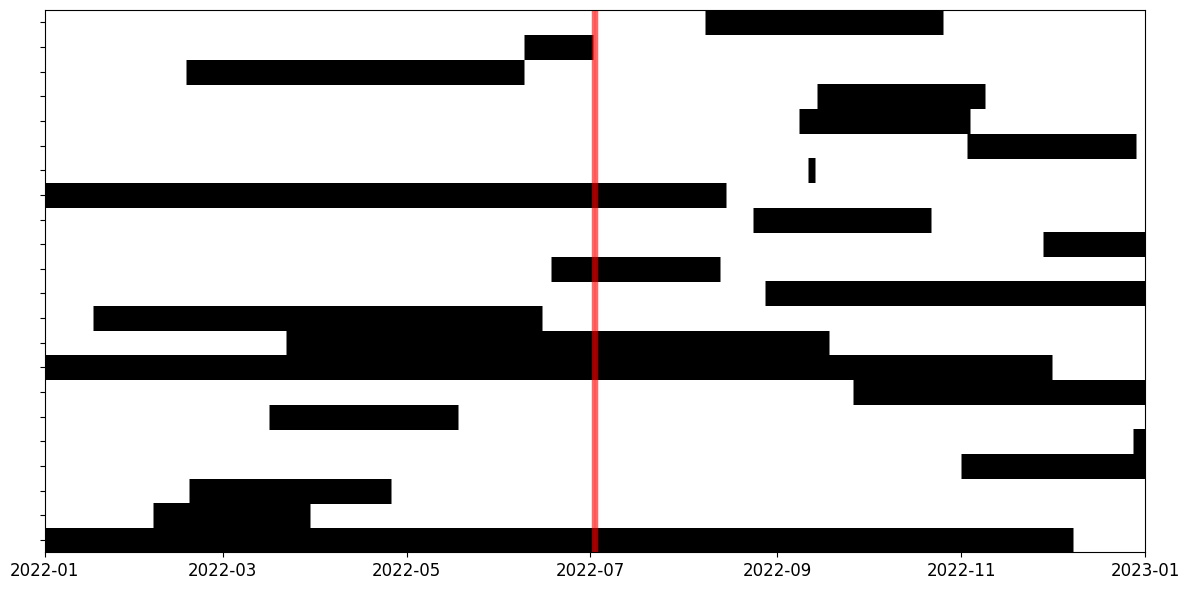

In [12]:
num_mustoffs = mustoff_2022.shape[0]
ymin, ymax = -0.5, num_mustoffs- 0.5
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hlines(
    y=range(num_mustoffs), 
    xmin=timestamp_2022[mustoff_2022[:, 1]], 
    xmax=timestamp_2022[mustoff_2022[:, 2]],
    lw=18,
    colors="black",
)
ax.vlines(
    x=[np.datetime64("2022-07-02T00"), np.datetime64("2022-07-02T23")],
    ymin=ymin,
    ymax=ymax,
    lw=2.5,
    color="red",
    alpha=0.6,
)
ax.set_xlim(timestamp_2022[0], timestamp_2022[-1] + 1)
ax.set_ylim(ymin, ymax)
ax.set_yticks(range(num_mustoffs))
ax.set_yticklabels([])
# ax.xaxis.get_majorticklabels()[-1].set_horizontalalignment("right")
# ax.xaxis.get_majorticklabels()[0].set_horizontalalignment("left")
ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

In [13]:
# solar = solar_p_max_2022.sum(axis=1)
# hist, bin_edges = np.histogram(solar, bins=np.linspace(solar.min(), solar.max(), 24), density=False)
# fig, ax = plt.subplots(1, 1)
# ax.bar((bin_edges[:-1] + bin_edges[1:]) / 2, hist / hist.sum() * 100, width=bin_edges[1] - bin_edges[0], color="red", edgecolor="black", linewidth=1)
# _, ymax = ax.get_ylim()
# ax.vlines(x=[solar.mean(), solar_capacity_2022.sum()], ymin=0, ymax=ymax, linestyles=":", lw=3, color=("gold", "gray"))
# ax.set_ylim(0, ymax)
# ax.set_xlim(0, solar_capacity_2022.sum() * 1.05)
# plt.tight_layout()
# plt.show()

# wind = wind_p_2022.sum(axis=1)
# hist, bin_edges = np.histogram(wind, bins=np.linspace(wind.min(), wind.max(), 24), density=False)
# fig, ax = plt.subplots(1, 1)
# ax.bar((bin_edges[:-1] + bin_edges[1:]) / 2, hist / hist.sum() * 100, width=bin_edges[1] - bin_edges[0], color="green", edgecolor="black", linewidth=1)
# _, ymax = ax.get_ylim()
# ax.vlines(x=[wind.mean(), wind_capacity_2022.sum()], ymin=0, ymax=ymax, linestyles=":", lw=3, color=("gold", "gray"))
# ax.set_ylim(0, ymax)
# ax.set_xlim(0, wind_capacity_2022.sum() * 1.05)
# plt.tight_layout()
# plt.show()


# hydro = hydro_p_2022.sum(axis=1)
# hist, bin_edges = np.histogram(hydro, bins=np.linspace(hydro.min(), hydro.max(), 24), density=False)
# fig, ax = plt.subplots(1, 1)
# ax.bar((bin_edges[:-1] + bin_edges[1:]) / 2, hist / hist.sum() * 100, width=bin_edges[1] - bin_edges[0], color="blue", edgecolor="black", linewidth=1)
# _, ymax = ax.get_ylim()
# ax.vlines(x=[hydro.mean(), hydro_capacity_2022.sum()], ymin=0, ymax=ymax, linestyles=":", lw=3, color=("gold", "gray"))
# ax.set_ylim(0, ymax)
# ax.set_xlim(0, hydro_capacity_2022.sum() * 1.05)
# plt.tight_layout()
# plt.show()

# lw, alpha=0.3, 1
# for reg_24, color, zorder in zip(
#     solar_p_max_2022.sum(axis=1).reshape((365, 24)), 
#     plt.colormaps["jet_r"](np.linspace(0, 1, 365)),
#     np.arange(365, 0, -1)
# ):
#     plt.plot(reg_24, lw=lw, c="red", alpha=alpha, zorder=zorder)
# plt.show()    

# for reg_24, color, zorder in zip(
#     wind_p_2022.sum(axis=1).reshape((365, 24)), 
#     plt.colormaps["jet_r"](np.linspace(0, 1, 365)),
#     np.arange(365, 0, -1)
# ):
#     plt.plot(reg_24, lw=lw, c="green", alpha=alpha, zorder=zorder)
# plt.show()

# for reg_24, color, zorder in zip(
#     hydro_p_2022.sum(axis=1).reshape((365, 24)), 
#     plt.colormaps["jet_r"](np.linspace(0, 1, 365)),
#     np.arange(365, 0, -1)
# ):
#     plt.plot(reg_24, lw=lw, c="blue", alpha=alpha, zorder=zorder)
# plt.show()

In [14]:
# # ---------- SOLAR -----------------------------------------------------------
# import numpy as np, matplotlib.pyplot as plt
# lw, alpha, labelsize = 0.3, 1.0, 20

# solar = solar_p_max_2022.sum(axis=1)                            # (8760,)
# hist, edges = np.histogram(solar, bins=np.linspace(solar.min(), solar.max(), 24))
# mid  = (edges[:-1] + edges[1:]) / 2
# barh = edges[1] - edges[0]
# cap  = solar_capacity_2022.sum()

# fig, (ax1, ax2) = plt.subplots(
#     1, 2, figsize=(15, 10), gridspec_kw={"width_ratios": [4, 1]}
# )

# # 24-h traces (365 lines)
# for reg24, z in zip(solar.reshape(365, 24), np.arange(365, 0, -1)):
#     ax1.plot(reg24, lw=lw, c="red", alpha=alpha, zorder=z)

# ax1.hlines([solar.mean(), cap], 0, 23, ls=":", lw=3, colors=("gold", "gray"))
# ax1.set_xlim(0, 23)
# ax1.set_ylim(0, cap * 1.05)
# ax1.set_xticks([0, 5, 11, 17, 23])
# ax1.set_xticklabels([1, 6, 12, 18, 24])
# ax1.set_yticks(np.unique(np.append(ax1.get_yticks(), cap)))
# ax1.tick_params(axis="both", direction="in", labelsize=labelsize)

# ax2.barh(mid, hist / hist.sum() * 100, height=barh, color="red",
#          edgecolor="black", lw=1)
# ax2.hlines([solar.mean(), cap], *ax2.get_xlim(), ls=":", lw=3,
#            colors=("gold", "gray"))
# ax2.set_xlim(0, 23)
# ax2.set_ylim(0, cap * 1.05)       # match y-range
# ax2.set_yticks([])                 # hide y-axis ticks/labels here
# ax2.tick_params(axis="x", direction="in", labelsize=labelsize)

# plt.tight_layout()
# plt.show()

# # ---------- WIND ------------------------------------------------------------
# import numpy as np, matplotlib.pyplot as plt
# lw, alpha, labelsize = 0.3, 1.0, 20

# wind = wind_p_2022.sum(axis=1)
# hist, edges = np.histogram(wind, bins=np.linspace(wind.min(), wind.max(), 24))
# mid  = (edges[:-1] + edges[1:]) / 2
# barh = edges[1] - edges[0]
# cap  = wind_capacity_2022.sum()

# fig, (ax1, ax2) = plt.subplots(
#     1, 2, figsize=(15, 10), gridspec_kw={"width_ratios": [4, 1]}
# )

# for reg24, z in zip(wind.reshape(365, 24), np.arange(365, 0, -1)):
#     ax1.plot(reg24, lw=lw, c="green", alpha=alpha, zorder=z)

# ax1.hlines([wind.mean(), cap], 0, 23, ls=":", lw=3, colors=("gold", "gray"))
# ax1.set_xlim(0, 23)
# ax1.set_ylim(0, cap * 1.05)
# ax1.set_xticks([0, 5, 11, 17, 23])
# ax1.set_xticklabels([1, 6, 12, 18, 24])
# ax1.set_yticks(np.unique(np.append(ax1.get_yticks(), cap)))
# ax1.tick_params(axis="both", direction="in", labelsize=labelsize)

# ax2.barh(mid, hist / hist.sum() * 100, height=barh, color="green",
#          edgecolor="black", lw=1)
# ax2.hlines([wind.mean(), cap], *ax2.get_xlim(), ls=":", lw=3,
#            colors=("gold", "gray"))
# ax2.set_xlim((0, 23))
# ax2.set_ylim(0, cap * 1.05)
# ax2.set_yticks([])
# ax2.tick_params(axis="x", direction="in", labelsize=labelsize)

# plt.tight_layout()
# plt.show()

# # ---------- HYDRO -----------------------------------------------------------
# import numpy as np, matplotlib.pyplot as plt
# lw, alpha, labelsize = 0.3, 1.0, 20

# hydro = hydro_p_2022.sum(axis=1)
# hist, edges = np.histogram(hydro, bins=np.linspace(hydro.min(), hydro.max(), 24))
# mid  = (edges[:-1] + edges[1:]) / 2
# barh = edges[1] - edges[0]
# cap  = hydro_capacity_2022.sum()

# fig, (ax1, ax2) = plt.subplots(
#     1, 2, figsize=(15, 10), gridspec_kw={"width_ratios": [4, 1]}
# )

# for reg24, z in zip(hydro.reshape(365, 24), np.arange(365, 0, -1)):
#     ax1.plot(reg24, lw=lw, c="blue", alpha=alpha, zorder=z)

# ax1.hlines([hydro.mean(), cap], 0, 23, ls=":", lw=3, colors=("gold", "gray"))
# ax1.set_xlim(0, 23)
# ax1.set_ylim(0, cap * 1.05)
# ax1.set_xticks([0, 5, 11, 17, 23])
# ax1.set_xticklabels([1, 6, 12, 18, 24])
# ax1.set_yticks(np.unique(np.append(ax1.get_yticks(), cap)))
# ax1.tick_params(axis="both", direction="in", labelsize=labelsize)

# ax2.barh(mid, hist / hist.sum() * 100, height=barh, color="blue",
#          edgecolor="black", lw=1)
# ax2.hlines([hydro.mean(), cap], *ax2.get_xlim(), ls=":", lw=3,
#            colors=("gold", "gray"))
# ax2.set_xlim((0, 23))
# ax2.set_ylim(0, cap * 1.05)
# ax2.set_yticks([])
# ax2.tick_params(axis="x", direction="in", labelsize=labelsize)

# plt.tight_layout()
# plt.show()


Generation Cost

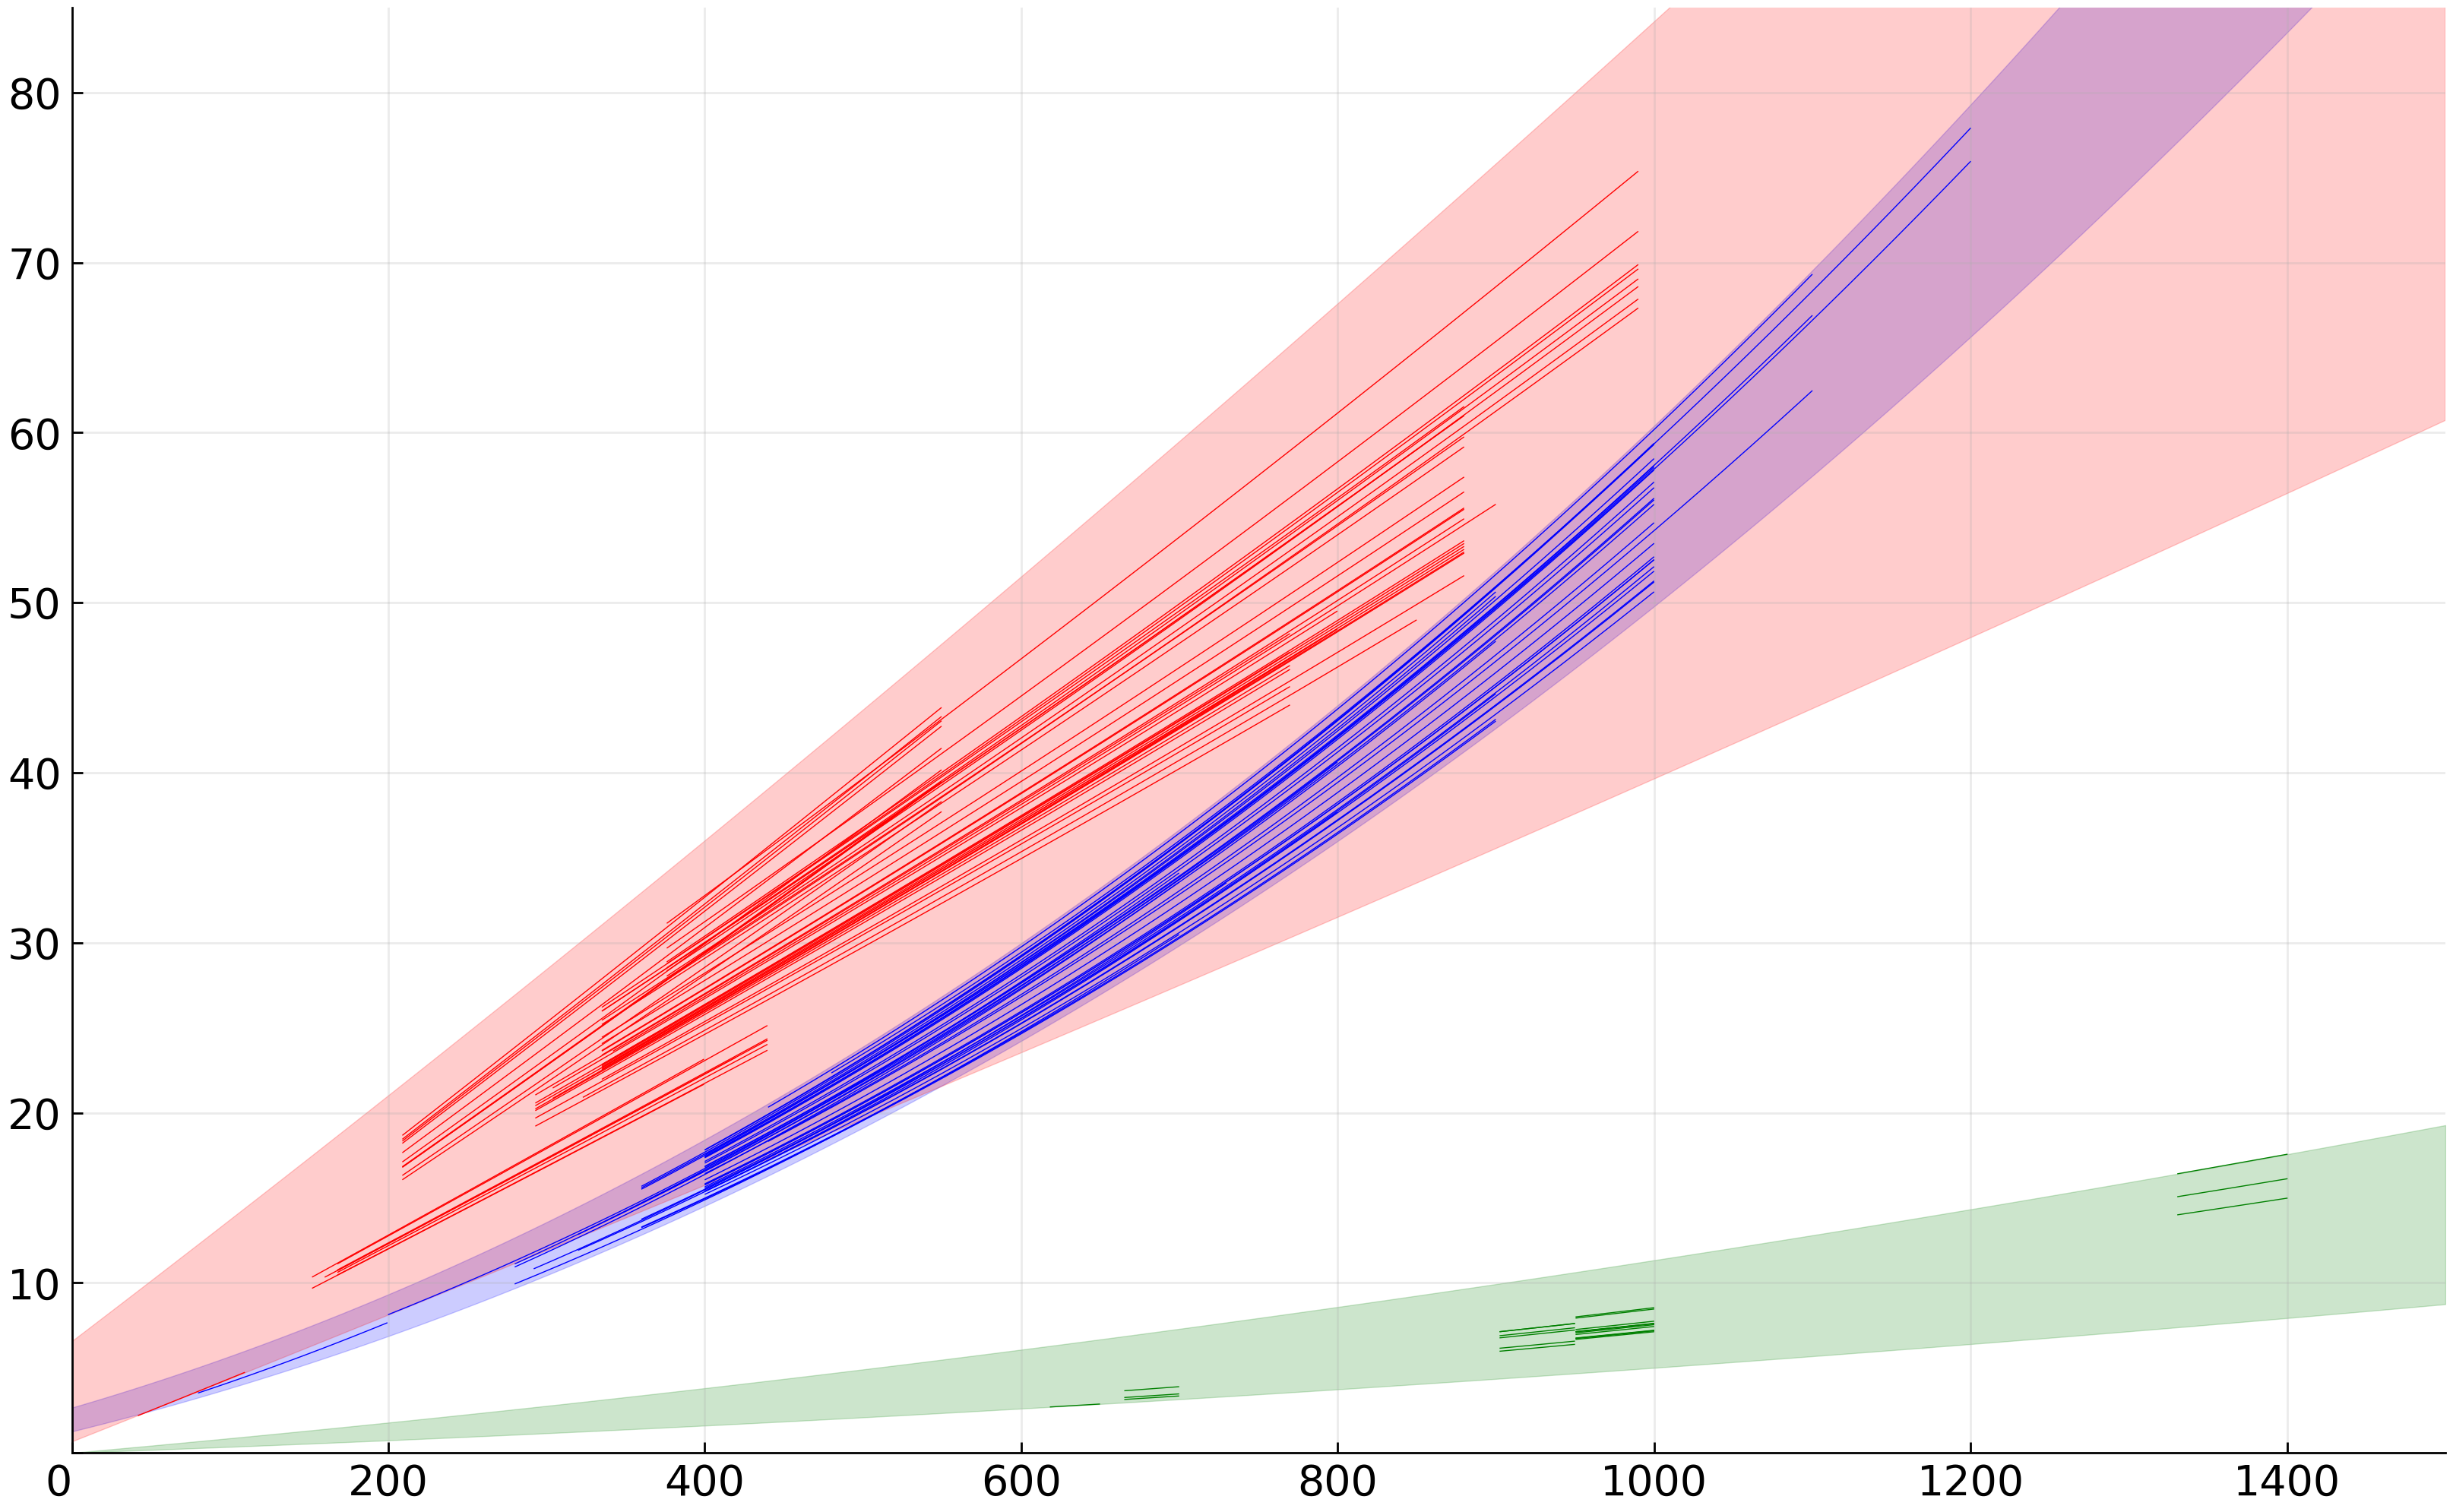

In [15]:
def quad_cost(ps, c_quad, c_lin, c_const):
    return (c_quad * ps**2 + c_lin * ps + c_const) / 1e6 # 1M KRW

ps_grid = np.linspace(0, 1500, 1500)
utype_colors = {0: "green", 1: "blue", 2: "red"}

fig, ax = plt.subplots(figsize=(20 * 1.619, 20))
fig_height = 20

for (c_quad, c_lin, c_const, pmin, pmax, utype) in zip(
    cost_quad,
    cost_lin,
    cost_const,
    p_min,
    p_max,
    unit_type,
):
    ps_i = ps_grid[(pmin <= ps_grid) & (ps_grid <= pmax)]
    ax.plot(ps_i, quad_cost(ps_i, c_quad, c_lin, c_const), linewidth=1, color=utype_colors[utype])

for utype, color in utype_colors.items():
    mask = (unit_type == utype)
    y_max = quad_cost(ps_grid, cost_quad[mask].max(), cost_lin[mask].max(), cost_const[mask].max())
    y_min = quad_cost(ps_grid, cost_quad[mask].min(), cost_lin[mask].min(), cost_const[mask].min())
    ax.fill_between(ps_grid, y_min, y_max, color=color, alpha=0.2)

ax.grid(linewidth=(fig_height / 10), alpha=0.25, zorder=0)
for side in ["top", "right"]:
    ax.spines[side].set_visible(False)
for side in ["bottom", "left"]:
    ax.spines[side].set_linewidth((fig_height / 10))

ax.tick_params(
    axis="both", which="major", direction="in",
    width=(fig_height / 10), length=10, labelsize=(fig_height * 2), pad=10
)

ax.get_xticklabels(minor=False)[0].set_horizontalalignment("right")
ax.get_yticklabels(minor=False)[0].set_visible(False)

ax.set_ylim(0, 85)
ax.set_xlim(0, 1500)

# ax.set_xlabel("Power Output (MW)", fontsize=(fig_height * 2))
# ax.set_ylabel("Cost of Generation (M KRW)", fontsize=(fig_height * 2))


plt.tight_layout()
plt.show()
# plt.savefig("Generation Cost.png", dpi=600, bbox_inches="tight", transparent=True, pad_inches=0)

**Legened**

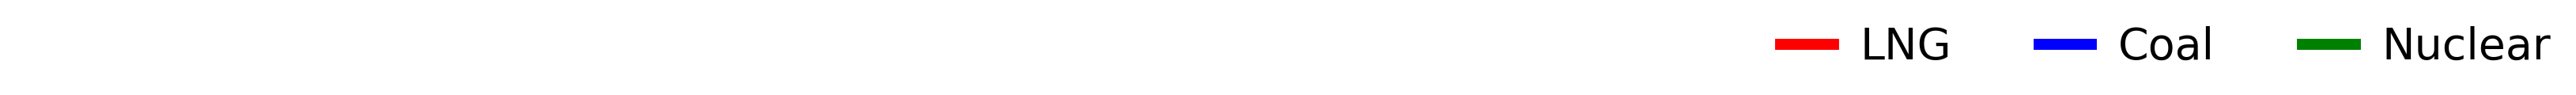

In [16]:
labels  = ["LNG", "Coal", "Nuclear"]
colors  = ["red",  "blue", "green"]

fig_width   = 20 * 1.619         # same width as the line plot
banner_ht   = fig_height / 20    # your preferred banner height
stroke_wt   = fig_height / 2     # keep handles visually consistent

# ── figure that has *no* default subplot paddings ────────────────────────────
legend_fig = plt.figure(figsize=(fig_width, banner_ht))

# add_axes([left, bottom, width, height]) → occupy 100 % of canvas
ax = legend_fig.add_axes([0, 0, 1, 1])
ax.axis("off")                   

handles = [Line2D([0], [0], color=c, lw=stroke_wt) for c in colors]

ax.legend(
    handles, labels,
    loc="center right",          # flush with right edge
    ncol=len(labels),            # horizontal
    frameon=False,
    borderaxespad=0,             # zero gap to the axes edge
    handlelength=1.2,
    handletextpad=0.6,
    prop={"size": fig_height * 2}
)

plt.show()
# legend_fig.savefig(
#     "Legend_Cost.png",
#     dpi=600,
#     transparent=True,
#     bbox_inches="tight",         # crop to exactly what is drawn
#     pad_inches=0                 # add absolutely no extra border
# )

**Startup Cost** 

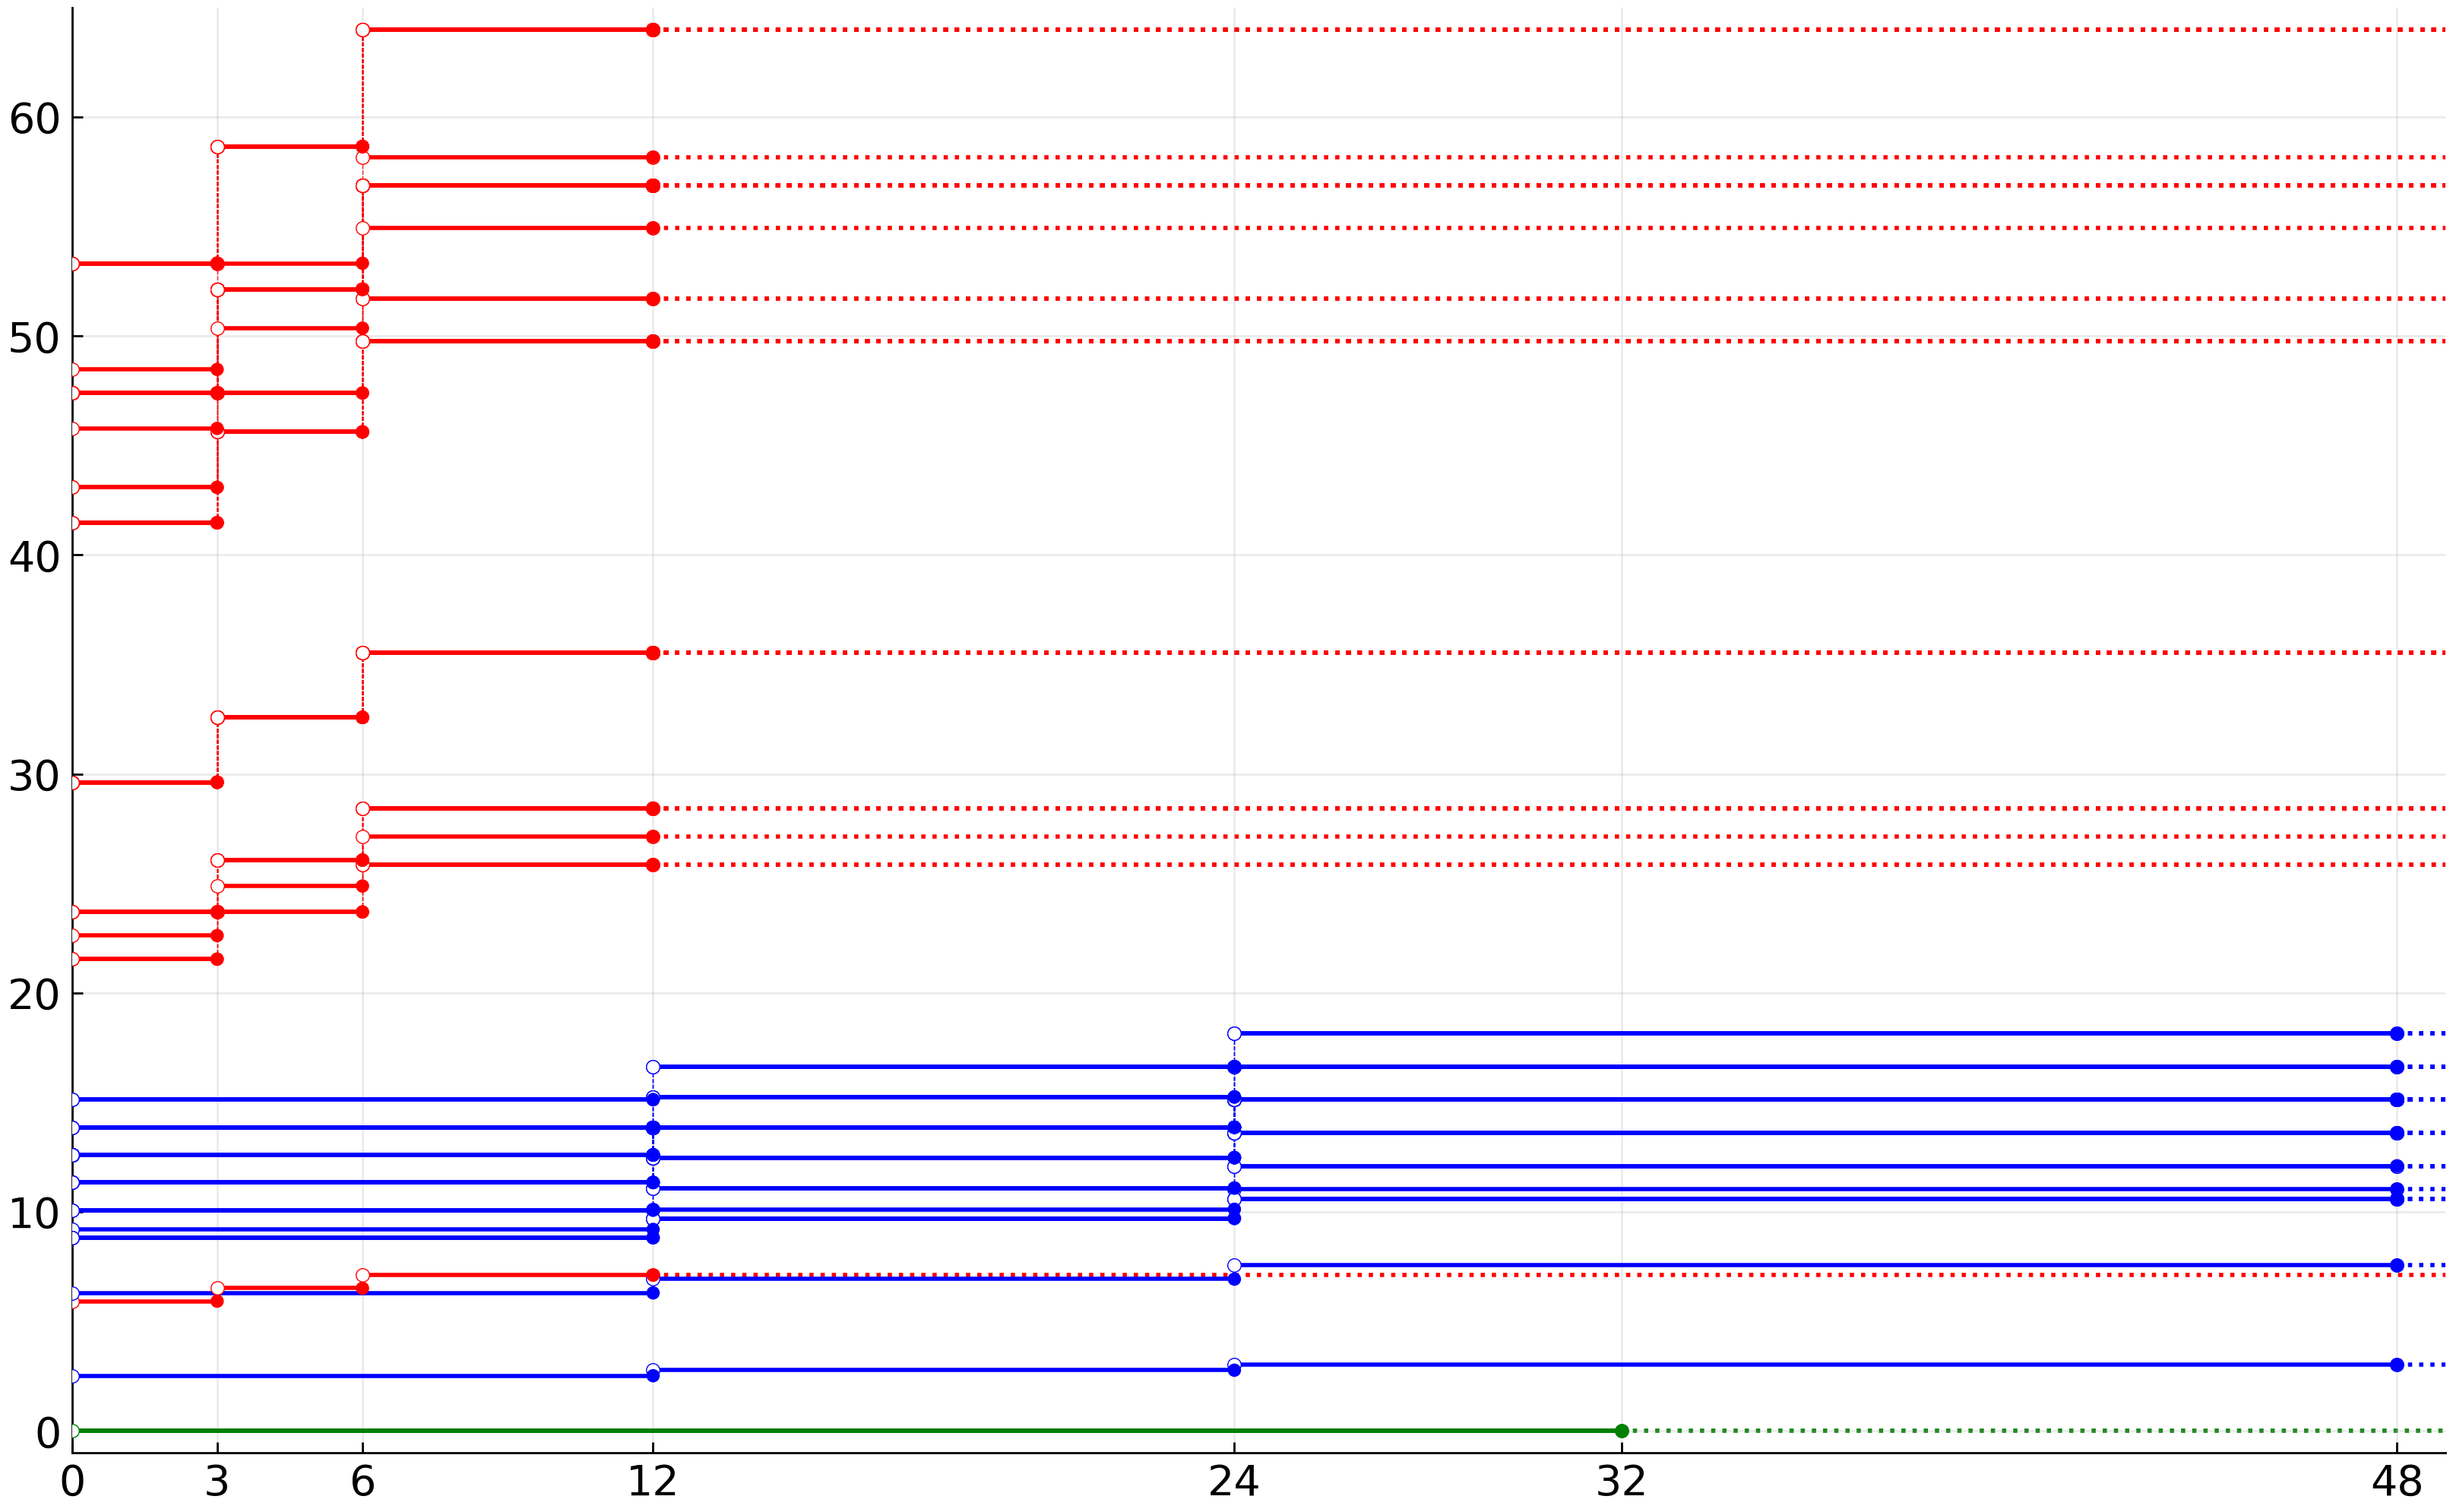

In [17]:
# ── helper : collapse full list into break-points of equal length ────────────
def startup_cost_series(cost_steps):
    """
    Convert [c1,c1,c1,c2,c2,c2,c3, …]  ➜  x=[0,3,6,12], y=[c1,c2,c3,c3]
    so that len(x) == len(y)   (required by ax.step).
    where='post' means the level changes *after* the tick mark.
    """
    cost = np.asarray(cost_steps, dtype=float) / 1e6
    n    = len(cost)

    # indices where the cost changes → break-points start at 0
    change_idx = np.where(np.diff(cost) != 0)[0] + 1       # e.g. [3,6]
    x   = np.concatenate(([0], change_idx, [n]))           # [0,3,6,12]
    y   = cost[x[:-1]]                                     # [c1,c2,c3]
    y   = np.append(y, y[-1])                              # duplicate last val
    return x, y

fig, ax = plt.subplots(figsize=(20 * 1.619, 20))
fig_height = 20
utype_colors = {0: "green", 1: "blue", 2: "red"}


# ── plotting loop (unchanged cosmetics) -------------------------------------
for cost_steps_i, utype_i in zip(cost_startup_step, unit_type):
    x_i, y_i = startup_cost_series(cost_steps_i)
    color = utype_colors[utype_i]

    # draw horizontal lines: from x[i] to x[i+1] at height y[i]
    for xi0, xi1, yi in zip(x_i[:-1], x_i[1:], y_i[:-1]):
        ax.plot([xi0, xi1], [yi, yi],
                color=color, linewidth=4, alpha=1, zorder=2)

    # draw vertical jumps: dashed from y[i] to y[i+1] at x[i+1]
    for xi, yi0, yi1 in zip(x_i[1:-1], y_i[:-2], y_i[1:-1]):
        if yi0 != yi1:
            ax.plot([xi, xi], [yi0, yi1],
                    linestyle="--", linewidth=1,
                    color=color, alpha=0.6, zorder=1.5)

    # ---- scatter points at the LOWER end of each vertical jump ------------
    cost = np.asarray(cost_steps_i, dtype=float) / 1e6
    change_idx = np.where(np.diff(cost) != 0)[0] + 1      # e.g. [3, 6, 12]

    if change_idx.size:
        x_pts = np.append(change_idx, len(cost_steps_i))       # include final step end
        y_pts = np.append(cost[change_idx - 1], cost[-1])      # last value = plateau level
        ax.scatter(
            x_pts, y_pts,
            s=fig_height * 8,
            color=utype_colors[utype_i],
            edgecolors="none",
            zorder=2000
        )


        x_pts = np.append(change_idx, len(cost_steps_i))       # include final step end
        y_pts = np.append(cost[change_idx], cost[-1])      # last value = plateau level
        ax.scatter(
            x_pts, y_pts,
            s=fig_height * 8,
            edgecolors=utype_colors[utype_i],
            facecolors="white",
            zorder=1000
        )

        # --- ADD white-faced scatter at x=0 -------------------------------
        ax.scatter(
            [0], [cost[0]],
            s=fig_height * 8,
            edgecolors=color,
            facecolors="white",
            zorder=1000,
        )

        # --- EXTEND final plateau as dashed line to x=50 ------------------
        # determine last segment end point
        cold_start_x = len(cost_steps_i)      # always 1, 12, or 48 for nuc/lng/coal
        cold_start_y = cost[-1]

        ax.plot(
            [cold_start_x, 50], [cold_start_y, cold_start_y],
            linestyle=":",
            linewidth=4,
            color=color,
            alpha=1,
            zorder=1.2,
        )


    
        for xi, y0, y1 in zip(change_idx, cost[change_idx - 1], cost[change_idx]):
            ax.plot([xi, xi], [y0, y1],
                    linestyle="--", linewidth=1,
                    color=utype_colors[utype_i], alpha=0.6, zorder=2.5)
            

ax.scatter(32, 0, s=(fig_height * 8), color="green", zorder=3)
ax.scatter(0, 0, s=(fig_height * 8), color="green", facecolor="white", zorder=1000)


ax.plot(
    [32, 50], [0, 0],
    linestyle=":",
    linewidth=4,
    color="green",
    alpha=1,
    zorder=1.2,
)

# ---------------------------------------------------------------------------
ax.grid(linewidth=(fig_height / 10), alpha=0.25, zorder=0)
for side in ["top", "right"]:
    ax.spines[side].set_visible(False)
for side in ["bottom", "left"]:
    ax.spines[side].set_linewidth((fig_height / 10))

ax.tick_params(
    axis="both", which="major", direction="in",
    width=(fig_height / 10), length=10, labelsize=(fig_height * 2), pad=10
)

ax.set_xticks([0, 3, 6, 12, 24, 32, 48])


ax.set_xlim(0, 49)
ax.set_ylim(-1, 65)

plt.tight_layout()
plt.show()
# plt.savefig("Startup Cost.png", dpi=600, bbox_inches="tight", transparent=True, pad_inches=0)